In [43]:
import cv2
import os
import numpy as np
from skimage.measure import label, regionprops
from skimage.metrics import structural_similarity
from scipy.stats import entropy, ttest_ind, shapiro, bartlett
from statsmodels.stats.multitest import multipletests

In [2]:
def calcCircularity(inImageGray):
      height, width = inImageGray.shape
      binImage = np.zeros((height, width))
      binImage[inImageGray > 0] = 1
      mask = label(binImage)
      #mask = binImage
      mask_props = regionprops(mask)
      soliditySum = 0
      areaSum = 0
      for mask_prop in mask_props: #due to neighbourhood adjacency, FG region might be split into regions....
        areaSize = mask_prop['area']  
        solidity = mask_prop['solidity']
        areaSum += areaSize
        soliditySum += solidity * areaSize
        
      soliditySum /= areaSum
      return soliditySum

In [3]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def calcCoprops(inImageGray):
    # Berechnen Sie die Graustufen-Ko-Okkurrenz-Matrix
    glcm = graycomatrix(inImageGray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)

    glcm[:, 0, :, :] = 0
    glcm[0, :, :, :] = 0
    # Berechnen Sie die Homogenität aus der GLCM
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    contrast = graycoprops(glcm, 'contrast')
    correlation = graycoprops(glcm, 'correlation')
    #maybe correlation?
    
    return np.mean(homogeneity), np.mean(energy), np.mean(contrast), np.mean(correlation)


In [4]:
def chromaticity(inImageBGR, inImageGray):
      r, g, b = cv2.split(inImageBGR)
      minChannel = np.minimum(r, g)
      minChannel = np.minimum(minChannel, b)

      maxChannel = np.maximum(r, g)
      maxChannel = np.maximum(maxChannel, b)

      diffImg = maxChannel - minChannel


      avgChromaticity = np.mean(diffImg[inImageGray > 0])

      return avgChromaticity

In [5]:
def calcEntropy(inImageGray):
    flat_image = inImageGray.flatten()

    histogram, _ = np.histogram(flat_image, bins=256, range=(0, 256))

    probabilities = histogram / flat_image.size
    
    entropy_value = entropy(probabilities, base=2)

    return entropy_value

In [6]:
real = [3, 8, 21, 24, 28]
with open("../texture_features.csv", "w") as outfile:
    outfile.write(f"circularity;homogenity;energy;contrast;correlation;chromaticity;entropy;group\n");
    for imageName in os.listdir(r"../data/grabCut"):
        image = cv2.imread(rf"../data/grabCut/{imageName}")
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        circ = calcCircularity(gray_img)
        homogenity, energy, contrast, correlation = calcCoprops(gray_img)
        chroma = chromaticity(image, gray_img)
        entropyVal = calcEntropy(gray_img)

        group = "real" if int(imageName.split(".")[0]) in real else "generated"
        
        outfile.write(f"{circ};{homogenity};{energy};{contrast};{correlation};{chroma};{entropyVal};{group}\n")


In [7]:
# show in fourier dimension
for imageName in os.listdir(r"../data/grabCut"):
    image = cv2.imread(rf"../data/grabCut/{imageName}")
    #image = cv2.imread(r"../Untitled.png")
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fourier = cv2.dft(np.float32(gray_img), flags=cv2.DFT_COMPLEX_OUTPUT)
     
    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)
     
    # calculate the magnitude of the Fourier Transform
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
     
    # Scale the magnitude for display
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    cv2.imwrite(rf"../data/fourier/{imageName}",magnitude)

In [18]:
import pandas as pd
data = pd.read_csv("../texture_features.csv", sep=";")
data

,circularity,homogenity,energy,contrast,correlation,chromaticity,entropy,group
0,0.996041,0.130267,0.012933,220.706396,0.945820,130.689901,4.670062,generated
1,0.991423,0.114190,0.010280,431.125885,0.941989,85.494683,6.454327,generated
2,0.887322,0.202094,0.021402,269.628390,0.973133,112.385317,5.114402,real
3,0.996162,0.121395,0.013350,203.206680,0.948110,125.244918,5.453984,generated
4,0.987383,0.137192,0.015249,382.698739,0.954901,120.526710,5.525590,real
5,0.990675,0.135882,0.013691,180.043501,0.958051,116.982717,6.442445,generated
6,0.993003,0.170566,0.014892,227.565828,0.954168,103.684600,4.650265,generated
7,0.987958,0.123866,0.012438,276.515033,0.925429,98.328894,6.073286,real
8,0.941993,0.086075,0.009514,502.903325,0.903646,93.112689,4.572491,real
9,0.950457,0.143458,0.012672,535.735296,0.903779,151.630760,6.348090,real


In [19]:
#data.drop(index=[5,8,9],inplace=True)
#data

In [20]:
sample_gen = data[data["group"]=="generated"]
sample_real = data[data["group"]=="real"]

In [47]:
df = pd.DataFrame(columns=["Feature", "t-p_value", "bartlett-p_value"])
for feature in data.columns.values[:-1]:
    t_statistic, p_value = ttest_ind(sample_gen[feature], sample_real[feature])
    bart_res = bartlett(sample_gen[feature], sample_real[feature])
    res1 = shapiro(sample_gen[feature]).pvalue > 0.05
    res2 = shapiro(sample_real[feature]).pvalue > 0.05
    if res1 and res2:
        print(feature, "\t" if len(feature) < 7 else "", "\t", "\t", t_statistic, "\t", p_value, "\t", bart_res.pvalue)
        df.loc[len(df.index)] = [feature, p_value, bart_res.pvalue]

df

circularity  	 	 2.2927694108596217 	 0.051043716492537895 	 0.00011377362298225188
homogenity  	 	 -0.19285680336068034 	 0.8518771852392323 	 0.23344337718915134
energy 	 	 	 -0.5717764106015131 	 0.5831776207509132 	 0.08770235802244539
correlation  	 	 1.2298633592407875 	 0.2536867591284859 	 0.010528531217032995
chromaticity  	 	 -0.2112817843033691 	 0.8379502961226188 	 0.6517382634924007
entropy  	 	 0.014516627463965263 	 0.9887733123349791 	 0.6758755933605045


,Feature,t-p_value,bartlett-p_value
0,circularity,0.051044,0.000114
1,homogenity,0.851877,0.233443
2,energy,0.583178,0.087702
3,correlation,0.253687,0.010529
4,chromaticity,0.837950,0.651738
5,entropy,0.988773,0.675876


In [58]:
corrected = multipletests(df["bartlett-p_value"], method='fdr_bh')
corrected

(array([ True, False, False,  True, False, False]),
 array([0.00068264, 0.35016507, 0.17540472, 0.03158559, 0.67587559,
        0.67587559]),
 0.008512444610847103,
 0.008333333333333333)

In [24]:
# The specified order
specified_order = [3, 8, 21, 24, 28]

# Define a custom sorting key function
def custom_sort_key(file_name):
    try:
        # Extract the numerical part from the file name
        number_part = int(file_name.split('.')[0])
        
        # Check if the number is in the specified order
        if number_part in specified_order:
            # Return a tuple with a lower priority to place it at the front
            return (0, specified_order.index(number_part))
    except ValueError:
        pass
    
    # Return a tuple with a higher priority for other cases
    return (1, file_name)

In [27]:
names = sorted(os.listdir(r"../data/grabCut"), key=custom_sort_key)
names

['03.png',
 '08.png',
 '21.png',
 '24.png',
 '28.png',
 '00.png',
 '02.png',
 '07.png',
 '10.png',
 '19.png']

In [32]:
ssim_matrix = np.zeros((len(names), len(names)))
for i, im1name in enumerate(names):
    for j, im2name in enumerate(names):
        image1 = cv2.imread(rf"../data/grabCut/{im1name}", cv2.IMREAD_GRAYSCALE)
        image2 = cv2.imread(rf"../data/grabCut/{im2name}", cv2.IMREAD_GRAYSCALE)

        # Get the shape (height and width) of both images
        height1, width1 = image1.shape
        height2, width2 = image2.shape
        
        # Resize the larger image to the size of the smaller one
        if height1 * width1 > height2 * width2:
            image1 = cv2.resize(image1, (width2, height2))
            image2 = image2
        else:
            image1 = image1
            image2 = cv2.resize(image2, (width1, height1))
        
        ssim_matrix[i][j], _ = structural_similarity(image1, image2, full=True)

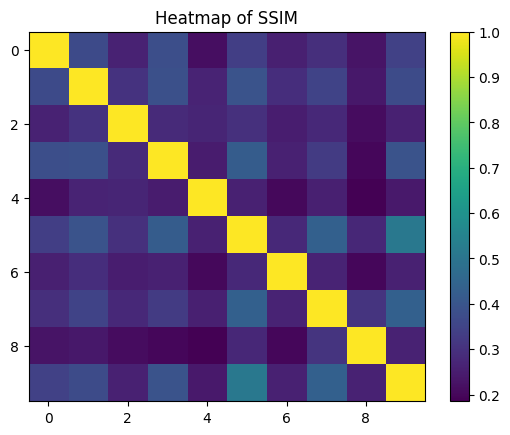

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [59]:
import matplotlib.pyplot as plt
# Display the heatmap
plt.imshow(ssim_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
plt.title('Heatmap of SSIM')
plt.colorbar()
plt.show()